In [146]:
import pandas as pd

df = pd.read_csv("data/testdata.manual.2009.06.14.csv", header=None)
df.columns = ["polarity","id","date","request","user","text"]
df.head()

,polarity,id,date,request,user,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


In [147]:
from nltk.tokenize import TweetTokenizer
import re

tk = TweetTokenizer()
slang_dict = {x.split("\t")[0]:x.split("\t")[1] for x in open("data/SlangLookupTable.txt","r",encoding='windows-1252').read().split("\n") if x}
hashtag_cnt = 0

def pre_traitement(tweet):
    # Segmenter
    # tweet = tweet.lower().split()
    tweet = tk.tokenize(tweet)
    global hashtag_cnt
    hashtag_cnt += sum([1 for x in tweet if x.startswith("#")])
    # Supprimer urls
    tweet = [re.sub(r'http\S+', '', x) for x in tweet]
    # Nettoyer caractères inhérents
    tweet = [x.strip("#@") for x in tweet] # Nettoyer emojis ?
    # Corriger slang
    tweet = [slang_dict.get(x, x) for x in tweet]
    return tweet

df["pre_traite"] = df["text"].apply(pre_traitement)
print(hashtag_cnt)

52


In [148]:
import nltk
from nltk.tag import map_tag

verb_cnt = 0

def postag(tweet):
    global verb_cnt
    tweet_pos = nltk.pos_tag(tweet)
    tags = [(x, map_tag("en-ptb", "universal", tag)) for x, tag in tweet_pos]
    verb_cnt += sum([1 for _, tag in tags if tag=="VERB"])
    return tags

df["pos_tags"] = df["pre_traite"].apply(postag)
print(verb_cnt)

1107


In [149]:
from nltk.corpus import wordnet as wn
from nltk.corpus.reader import sentiwordnet as swn

swn_dict = swn.SentiWordNetCorpusReader('', ['data/SentiWordNet_3.0.0_20130122.txt'])

def sent_from_tweet(tweet):
    posdict = {"ADJ":"a", "VERB":"v", "NOUN":"n", "ADV":"r"}
    tweet_filter = [(x, posdict[tag]) for x, tag in tweet if tag in ["ADJ","VERB","NOUN","ADV"]]
    pos = 0
    neg = 0
    for x, tag in tweet_filter:
        syns = wn.synsets(x, tag)
        for syn in syns:
            if syn.name().split(".")[0]==x:
                pos += swn_dict.senti_synset(syn.name()).pos_score()
                neg += swn_dict.senti_synset(syn.name()).neg_score()
                break
    if pos-neg<0:
        sentiment = 0
    elif pos-neg>0:
        sentiment = 4
    else:
        sentiment = 2
    return (pos,neg,sentiment)

df["sentiwordnet"] = df["pos_tags"].apply(sent_from_tweet)
df["sentiwordnet"]

0        (1.0, 0.125, 4)
1          (1.0, 0.0, 4)
2          (0.0, 0.0, 2)
3      (1.125, 0.875, 4)
4        (0.375, 0.0, 4)
             ...        
493        (0.0, 0.0, 2)
494        (0.0, 3.5, 0)
495        (0.0, 0.0, 2)
496        (0.0, 0.0, 2)
497      (0.25, 1.25, 0)
Name: sentiwordnet, Length: 498, dtype: object

Accuracy: 0.5381526104417671
F1: 0.5356474443273425


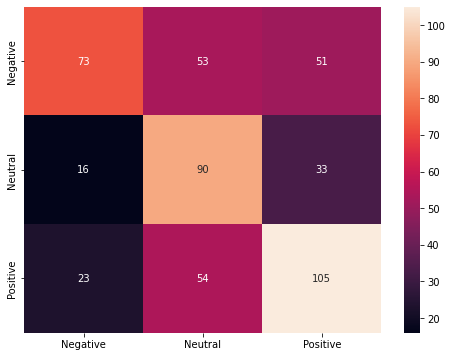

In [150]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


df["sentiwordnet_preds"] = df["sentiwordnet"].apply(lambda x: x[2])

print("Accuracy:",accuracy_score(df["polarity"], df["sentiwordnet_preds"]))
print("F1:", f1_score(df["polarity"], df["sentiwordnet_preds"], average="macro"))

classes = ["Negative","Neutral","Positive"]

cm = confusion_matrix(df["polarity"], df["sentiwordnet_preds"])
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)
plt.show()

In [151]:
modifiers = [x.split("\t")[0] for x in open("data/BoosterWordList.txt","r").read().split("\n") if x]
negating = [x.split("\t")[0] for x in open("data/NegatingWordList.txt","r").read().split("\n") if x]

neg_in_pos_cnt = 0

def sent_from_tweet2(tweet):
    global neg_in_pos_cnt
    posdict = {"ADJ":"a", "VERB":"v", "NOUN":"n", "ADV":"r"}
    tweet_filter = [(x, posdict[tag]) for x, tag in tweet if tag in ["ADJ","VERB","NOUN","ADV"]]
    pos = 0
    neg = 0
    curr_cnt = 0
    for i, (x, tag) in enumerate(tweet_filter):
        syns = wn.synsets(x, tag)
        for syn in syns:
            if syn.name().split(".")[0]==x:
                if i-1 > 0:
                    if tweet_filter[i-1][0] in negating:
                        neg += swn_dict.senti_synset(syn.name()).pos_score()
                        pos += swn_dict.senti_synset(syn.name()).neg_score()
                    elif tweet_filter[i-1][0] in modifiers:
                        pos += 2*swn_dict.senti_synset(syn.name()).pos_score()
                        neg += 2*swn_dict.senti_synset(syn.name()).neg_score()
                    else:
                        pos += swn_dict.senti_synset(syn.name()).pos_score()
                        neg += swn_dict.senti_synset(syn.name()).neg_score()
                else:
                    pos += swn_dict.senti_synset(syn.name()).pos_score()
                    neg += swn_dict.senti_synset(syn.name()).neg_score()
                if swn_dict.senti_synset(syn.name()).neg_score() != 0:
                    curr_cnt += 1
                break
    if pos-neg<0:
        sentiment = 0
        neg_in_pos_cnt += curr_cnt
    elif pos-neg>0:
        sentiment = 4
    else:
        sentiment = 2
    return (pos,neg,sentiment)

df["sentiwordnet2"] = df["pos_tags"].apply(sent_from_tweet2)
print(neg_in_pos_cnt)

165


Accuracy: 0.536144578313253
F1: 0.53387961729161


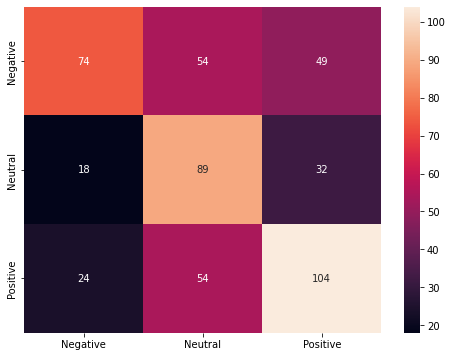

In [152]:
df["sentiwordnet2_preds"] = df["sentiwordnet2"].apply(lambda x: x[2])

classes = ["Negative","Neutral","Positive"]

print("Accuracy:",accuracy_score(df["polarity"], df["sentiwordnet2_preds"]))
print("F1:", f1_score(df["polarity"], df["sentiwordnet2_preds"], average="macro"))

cm = confusion_matrix(df["polarity"], df["sentiwordnet2_preds"])
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)
plt.show()

In [153]:
emotes = {x.split("\t")[0]:x.split("\t")[1] for x in open("data/EmoticonLookupTable.txt","r").read().split("\n") if x}

emote_cnt = 0

def sent_from_tweet3(tweet):
    global emote_cnt
    posdict = {"ADJ":"a", "VERB":"v", "NOUN":"n", "ADV":"r"}
    tweet_filter = [(x, posdict[tag]) for x, tag in tweet if tag in ["ADJ","VERB","NOUN","ADV"]]
    pos = 0
    neg = 0
    for i, (x, tag) in enumerate(tweet_filter):
        syns = wn.synsets(x, tag)
        for syn in syns:
            if syn.name().split(".")[0]==x:
                if i-1 > 0:
                    if tweet_filter[i-1][0] in negating:
                        neg += swn_dict.senti_synset(syn.name()).pos_score()
                        pos += swn_dict.senti_synset(syn.name()).neg_score()
                    elif tweet_filter[i-1][0] in modifiers:
                        pos += 2*swn_dict.senti_synset(syn.name()).pos_score()
                        neg += 2*swn_dict.senti_synset(syn.name()).neg_score()
                    else:
                        pos += swn_dict.senti_synset(syn.name()).pos_score()
                        neg += swn_dict.senti_synset(syn.name()).neg_score()
                else:
                    pos += swn_dict.senti_synset(syn.name()).pos_score()
                    neg += swn_dict.senti_synset(syn.name()).neg_score()
                break
        if emotes.get(x, None):
            emote_cnt += 1
            if emotes.get(x) == "1":
                pos += 1
            else:
                neg += 1
    if pos-neg<0:
        sentiment = 0
    elif pos-neg>0:
        sentiment = 4
    else:
        sentiment = 2
    return (pos,neg,sentiment)

df["sentiwordnet3"] = df["pos_tags"].apply(sent_from_tweet3)
print(emote_cnt)

56


Accuracy: 0.570281124497992
F1: 0.5678478842397227


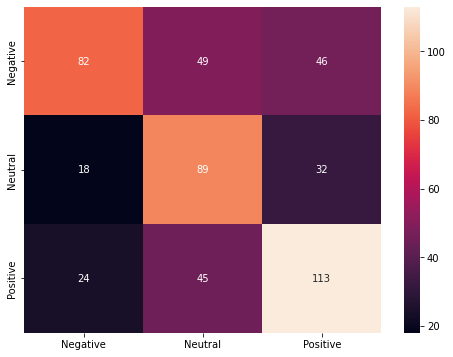

In [154]:
df["sentiwordnet3_preds"] = df["sentiwordnet3"].apply(lambda x: x[2])

print("Accuracy:",accuracy_score(df["polarity"], df["sentiwordnet3_preds"]))
print("F1:", f1_score(df["polarity"], df["sentiwordnet3_preds"], average="macro"))

classes = ["Negative","Neutral","Positive"]

cm = confusion_matrix(df["polarity"], df["sentiwordnet3_preds"])
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)
plt.show()

In [155]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()
def vader_pred(x):
    polarity_dict = sia.polarity_scores(x)
    if polarity_dict["pos"]>polarity_dict["neg"]:
        return 4
    elif polarity_dict["neg"]>polarity_dict["pos"]:
        return 0
    else:
        return 2

df["vader_pred"] = df["text"].apply(vader_pred)

Accuracy: 0.714859437751004
F1: 0.712411754647385


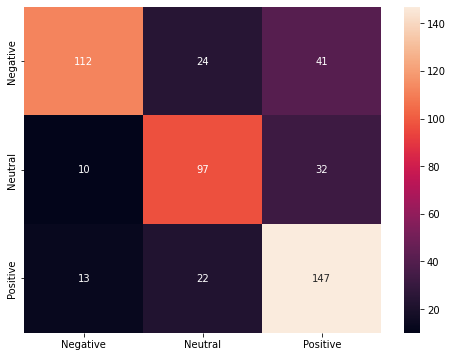

In [156]:
print("Accuracy:",accuracy_score(df["polarity"], df["vader_pred"]))
print("F1:", f1_score(df["polarity"], df["vader_pred"], average="macro"))

cm = confusion_matrix(df["polarity"], df["vader_pred"])
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)
plt.show()